In [8]:
import numpy as np
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Pre-procesamiento de imágenes

Función para convertir imágenes a vectores normalizados en escala de grises:

In [31]:
# def image_convert(dir, new_size):

#     imagenes = []

#     for filename in os.listdir(dir):

#         file_path = os.path.join(dir, filename)
#         print(f"Procesando imagen {file_path}")
        
#         if os.path.isfile(file_path):

#             # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
#             if not filename.lower().endswith('.png'):
#                 continue
#             try:
#                 with Image.open(file_path) as img:
#                     img = img.resize(new_size) 
#                     img = img.convert('L') # Convertir a escala de grises
#                     img_array = np.array(img)/255.0 # Convertir a array y normalizar
#                     img_vector = img_array.reshape((new_size[0]**2)) 
#                     imagenes.append(img_vector)
#             except Exception as e:
#                 print(f"Error procesando la imagen {file_path}: {e}")

#     return np.array(imagenes)



def image_convert(dir, new_size):
    imagenes = []
    errores = []

    extensiones_validas = ('.png', '.png ')

    total_imgs = 0
    procesadas = 0

    # archivos_png = [f for f in os.listdir(dir)]
    # print(f"Total de archivos PNG en la carpeta {dir}: {len(archivos_png)}")


    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        
        if os.path.isfile(file_path) and filename.lower().endswith(extensiones_validas):
            total_imgs += 1
            print(f"Procesando imagen {file_path}")

            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size)
                    img = img.convert('L')  # Escala de grises
                    img_array = np.array(img) / 255.0
                    img_vector = img_array.reshape((new_size[0]**2))
                    imagenes.append(img_vector)
                    procesadas += 1
            except Exception as e:
                errores.append((filename, str(e)))
                print(f"Error procesando {filename}: {e}")
    
    print(f"Imágenes procesadas: {procesadas}/{total_imgs}")
    if errores:
        print(f"{len(errores)} errores encontrados:")
        for fname, err in errores:
            print(f" - {fname}: {err}")

    return np.array(imagenes)


Configuramos los tamaños y elegimos aquel que se utilizará para los experimentos:

In [10]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = mediano

In [32]:
# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")

cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

print(f"Tamaño de las imágenes: {size} = {size[0] * size[1]} pixeles")

Procesando imagen DatasetTP/Healthy\Healthy1.png
Procesando imagen DatasetTP/Healthy\Healthy1000.png
Procesando imagen DatasetTP/Healthy\Healthy1001.png
Procesando imagen DatasetTP/Healthy\Healthy1002.png
Procesando imagen DatasetTP/Healthy\Healthy1003.png
Procesando imagen DatasetTP/Healthy\Healthy1004.png
Procesando imagen DatasetTP/Healthy\Healthy1005.png
Procesando imagen DatasetTP/Healthy\Healthy1021.png
Procesando imagen DatasetTP/Healthy\Healthy1022.png
Procesando imagen DatasetTP/Healthy\Healthy1023.png
Procesando imagen DatasetTP/Healthy\Healthy1027.png
Procesando imagen DatasetTP/Healthy\Healthy1028.png
Procesando imagen DatasetTP/Healthy\Healthy1029.png
Procesando imagen DatasetTP/Healthy\Healthy103.png
Procesando imagen DatasetTP/Healthy\Healthy1033.png
Procesando imagen DatasetTP/Healthy\Healthy1034.png
Procesando imagen DatasetTP/Healthy\Healthy1035.png
Procesando imagen DatasetTP/Healthy\Healthy1039.png
Procesando imagen DatasetTP/Healthy\Healthy104.png
Procesando imagen

Separamos en conjuntos de entrenamiento y test:

In [13]:
cant_healthy_train = round(cant_healthy * 0.7) # 70% de las imágenes sanas para entrenamiento
cant_healthy_test = cant_healthy - cant_healthy_train # 30% de las imágenes sanas para test

cant_park_train = round(cant_park * 0.7) # 70% de las imágenes con Parkinson para entrenamiento
cant_park_test = cant_park - cant_park_train # 30% de las imágenes con Parkinson para test

print(f"Entrenamiento - Sanos: {cant_healthy_train}, Parkinson: {cant_park_train}")
print(f"Test - Sanos: {cant_healthy_test}, Parkinson: {cant_park_test}")

# Dividimos las imágenes en entrenamiento y test
i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train])) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train])) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:])) # Imágenes de test
d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:])) # Diagnósticos de test

print(f"Entrenamiento: {i_train.shape}, {d_train.shape}")
print(f"Test: {i_test.shape}, {d_test.shape}")

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

indices = np.random.permutation(i_test.shape[0])
i_test = i_test[indices]
d_test = d_test[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0)


Entrenamiento - Sanos: 571, Parkinson: 571
Test - Sanos: 245, Parkinson: 245
Entrenamiento: (1142, 16384), (1142, 1)
Test: (490, 16384), (490, 1)
True


Queremos minimizar la función de pérdida:

$$
\sum_{i=1}^{N} \left( f^*(\mathbf{i}_i) - d_i \right)^2
$$

Es decir, queremos minimizar la diferencia entre los diagnósticos que predice el modelo y los reales. 

Buscamos la mejor solución dentro de las funciones $f : \mathbb{R}^K \to (0, 1)$
 que tengan la forma:

$$
f_{\mathbf{w}, b}(\mathbf{i}) = \frac{\tanh(\mathbf{w} \cdot \mathbf{i} + b) + 1}{2}
$$


donde $w$ es un vector de pesos (weights) de $\mathbb{R}^K$ , $b$ (bias) un escalar, y $tanh$ la tangente hiperbólica.

## Parte 1: Descenso de gradiente

Derivadas parciales:
$$
\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = 
\arg\min_{\mathbf{w}, b} \sum_{i=1}^{N} \left( f_{\mathbf{w}, b}(\mathbf{i}_i) - d_i \right)^2
$$


Derivamos $\mathcal{L}$ con respecto a $b$ (bias) y $w$ (weight):

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial w} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)\cdot i
$$

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial b} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)
$$

Funciones base:

In [14]:
def fwb(i, w, b):
    z = i@w + b 
    f = (np.tanh(z) + 1) / 2 
    return f 

In [15]:
# Error cuadrático total
def funcion_objetivo_desc(w, b, i, d):
    f = fwb(i, w, b)
    return np.sum((f - d) ** 2)

In [16]:
# Derivada parcial respecto a w
def df_w_desc(w, b, i, d):
    z = i@w + b
    f = (np.tanh(z) + 1) / 2
    
    dz = (1 - np.tanh(z) ** 2) * (f - d)  
    grad_w = i.T @ dz                  
    return grad_w

In [17]:
# Derivada parcial respecto a b
def df_b_desc(w, b, i, d):
    z = i@w + b
    f = (np.tanh(z) + 1) / 2
    
    dz = (1 - np.tanh(z) ** 2) * (f - d)
    # grad_b = np.sum(dz, axis=0, keepdims=True)  # Da forma (1,1)
    grad_b = np.sum(dz)  # Da un número escalar, que luego se maneja como vector donde todas las coordenadas son iguales
    return grad_b

In [18]:
def accuracy_desc(i, d, w, b):
    f = fwb(i, w, b) >= 0.5 # Aplicamos la función de activación y comparamos con 0.5
    return np.mean(f == d) * 100  # Porcentaje de aciertos

## Descenso de gradiente

In [ ]:
MAX_ITER = 2000

TOLERANCIA = 1e-8 

def gradient_descent(w, b, imagenes_train, diagnosticos_train, imagenes_test, diagnosticos_test, alpha=0.1, normalizar=False):
    
    if normalizar:
      imagenes_train = imagenes_train / np.max(imagenes_train)
      imagenes_test = imagenes_test / np.max(imagenes_test)

    iter  = 0
    valores_train = []
    valores_test = []
    acc_train = []
    acc_test = []

    while iter <= MAX_ITER:
        
        loss_train = funcion_objetivo_desc(w, b, imagenes_train, diagnosticos_train)
        print("Iteración: ", iter, "- Mínimo alcanzado hasta el momento: ", loss_train)

        valores_train.append(loss_train)
        acc_train.append(accuracy_desc(imagenes_train, diagnosticos_train, w, b))

        valores_test.append(funcion_objetivo_desc(w, b, imagenes_test, diagnosticos_test))
        acc_test.append(accuracy_desc(imagenes_test, diagnosticos_test, w, b)) 

        gradiente_w = df_w_desc(w, b, imagenes_train, diagnosticos_train) 
        gradiente_b = df_b_desc(w, b, imagenes_train, diagnosticos_train)

        # Control de norma del gradiente
        max_norm = 100.0
        norm_w = np.linalg.norm(gradiente_w)
        if norm_w > max_norm:
            gradiente_w = gradiente_w * (max_norm / norm_w)

        print("Norma gradiente_w:", np.linalg.norm(gradiente_w))
        print("gradiente_b:", gradiente_b)
    
        # # Si gradiente_b no es escalar, colapsar con promedio o suma
        if gradiente_b.ndim > 0 and gradiente_b.size > 1:
          gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

        # Actualización 
        w_sig = w - alpha * gradiente_w
        b_sig = b - alpha * gradiente_b

        # Criterio de convergencia
        criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, imagenes_train, diagnosticos_train) - funcion_objetivo_desc(w, b, imagenes_train, diagnosticos_train))

        if criterio < TOLERANCIA: # Converge
          print("Criterio de convergencia alcanzado en iteración", iter)
          break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_train, valores_test, acc_train, acc_test

In [20]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.001
b = np.random.uniform(-1, 1) * 0.001
alpha = 1e-7
normalizar = False
w_opt, b_opt, valores_train, valores_test, acc_train, acc_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)


Iteración:  0 - Mínimo alcanzado hasta el momento:  286.19766329091317
Norma gradiente_w: 100.0
gradiente_b: -34.38242134981526
Iteración:  1 - Mínimo alcanzado hasta el momento:  286.16301570274004
Norma gradiente_w: 100.0
gradiente_b: -33.791616608564894
Iteración:  2 - Mínimo alcanzado hasta el momento:  286.12899611705154
Norma gradiente_w: 100.0
gradiente_b: -33.20060143181141
Iteración:  3 - Mínimo alcanzado hasta el momento:  286.09560462710004
Norma gradiente_w: 100.0
gradiente_b: -32.60938415586777
Iteración:  4 - Mínimo alcanzado hasta el momento:  286.0628413135993
Norma gradiente_w: 100.0
gradiente_b: -32.01797334790592
Iteración:  5 - Mínimo alcanzado hasta el momento:  286.03070624420957
Norma gradiente_w: 100.00000000000001
gradiente_b: -31.426377827979653
Iteración:  6 - Mínimo alcanzado hasta el momento:  285.9991994729729
Norma gradiente_w: 100.00000000000001
gradiente_b: -30.834606693677365
Iteración:  7 - Mínimo alcanzado hasta el momento:  285.96832103969194
Norma 

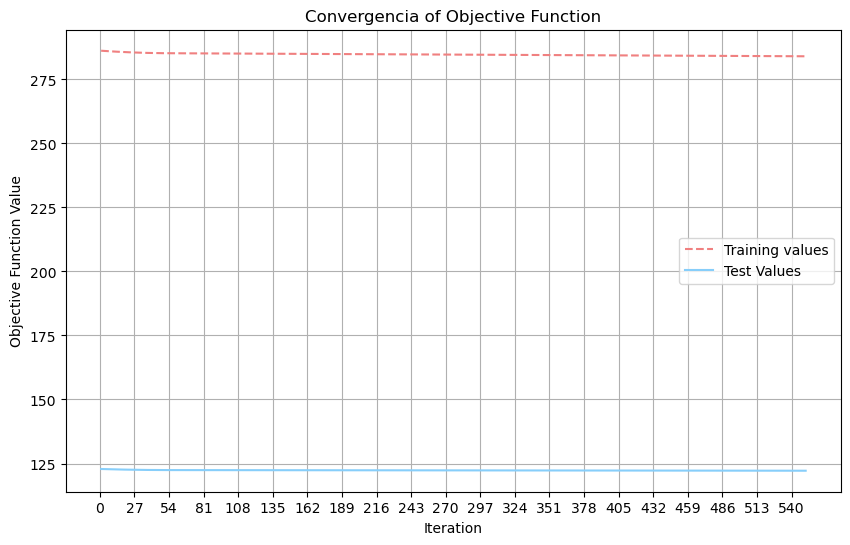

In [21]:
plt.figure(figsize=(10, 6))

# train
plt.plot(np.arange(1, len(valores_train) + 1), valores_train, linestyle='--', color='lightcoral', label='Training values')
# test
plt.plot(np.arange(1, len(valores_test) + 1), valores_test, linestyle='-', color='lightskyblue', label='Test Values')

tick_interval = max(1, len(valores_train) // 20)
plt.xticks(np.arange(0, len(valores_train) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergencia of Objective Function')
plt.grid(True)
plt.legend()  
plt.show()


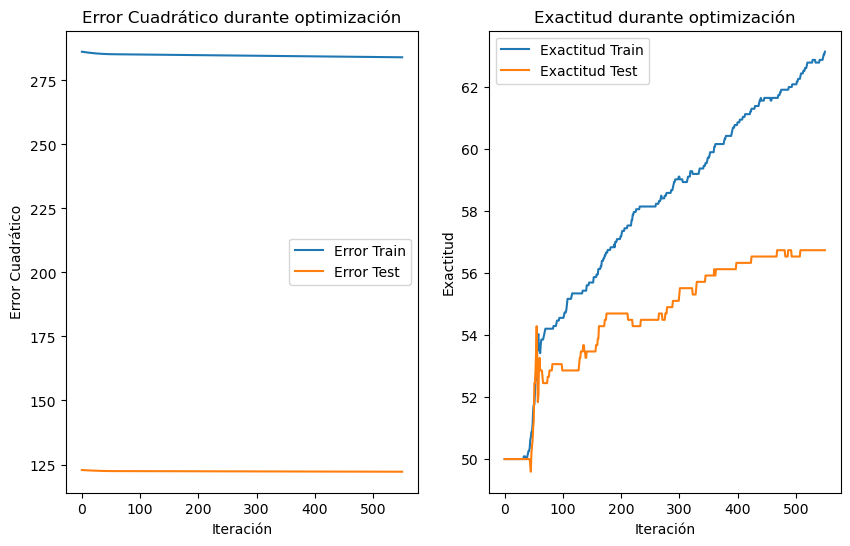

In [22]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.plot(valores_train, label='Error Train')
if valores_test:
    plt.plot(valores_test, label='Error Test')
plt.title('Error Cuadrático durante optimización')
plt.xlabel('Iteración')
plt.ylabel('Error Cuadrático')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc_train, label='Exactitud Train')
if acc_test:
    plt.plot(acc_test, label='Exactitud Test')
plt.title('Exactitud durante optimización')
plt.xlabel('Iteración')
plt.ylabel('Exactitud')
plt.legend()

plt.show()

In [23]:
# w, b, valores_train, valores_test, acc_train, acc_test = gradient_descent(
#      b=np.zeros((1, 1)), 
#      w=np.zeros((i_train.shape[1], 1)), 
#      imagenes_train=i_train, 
#      diagnosticos_train=d_train, 
#      imagenes_test=i_test, 
#      diagnosticos_test=d_test, 
#      alpha=0.01,
#      normalizar=False
# )

# plt.plot(valores_train, label="Entrenamiento")
# plt.plot(valores_test, label="Test")
# plt.xlabel("Iteración")
# plt.ylabel("Pérdida (loss)")
# plt.title("Gradient Descent - Alpha = 0.01")
# plt.legend()
# plt.grid(True)
# plt.show()

In [24]:
#w, b, valores_train, valores_test = gradiente_descendente(
#     b=np.zeros((1, 1)), 
#     w=np.zeros((i_train.shape[1], 1)), 
#     imagenes_train=i_train, 
#     diagnosticos_train=d_train, 
#     imagenes_test=i_test, 
#     diagnosticos_test=d_test, 
#     alpha=0.0
# )

# plt.plot(valores_train, label="Entrenamiento")
# plt.plot(valores_test, label="Test")
# plt.xlabel("Iteración")
# plt.ylabel("Pérdida (loss)")
# plt.title("Gradient Descent - Alpha = 0.009")
# plt.legend()
# plt.grid(True)
# plt.show()

## Ascenso de gradiente